# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [1]:
#Auxiliar function for ensuring absolute/percentage window size management
window_size_percentage = False
if (not window_size_percentage):
    from copy import deepcopy
    def ensure_expected_window_size(expected_window_size, print_flag: bool = False):
        window_size = deepcopy(expected_window_size)
        if print_flag: print(window_size)
        window_size[0] = window_size[0] / window_size[1]
        if print_flag: 
            print(window_size)
            print(int(round(window_size[0]*window_size[1])))
        return window_size
    def check_expected_window_size(learn, expected_window_size, print_flag: bool = False):
        # Find MVP calback
        obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
        if print_flag: print("obtained percentage", obtained_window_size)
        obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))
        if print_flag: print("obtained absolute", obtained_window_size)
        return obtained_window_size == expected_window_size

In [2]:
# This is only needed if the notebook is run in VSCode
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

In [3]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_long_term_forecasting_splits, get_forecasting_splits #TODO: Quitar 1 cuando esté decidida la opción

import wandb
wandb_api = wandb.Api()



## Setup CUDA

In [4]:
#cuda_device=1
cuda_device=0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:2048'

## Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [5]:
import nbs_pipeline.utils.config as cfg
user, project, version, data, config, job_type = cfg.get_artifact_config_MVP_SWV(False)

Changing to online analysis mode - use_wandb=true


In [6]:
cfg.force_artifact_config_mvp(config, 4, True, True)

alias: Monash-Australian_electricity_demand
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (15, 30) -> [1, 4320]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15 -> 144
train_artifact: mi-santamaria/deepvats/Monash-Australian_electricity_demand:latest -> mi-santamaria/deepvats/Monash-Solar_10_minutes:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30 -> 4320
wandb_group: None


In [7]:
#config.w = 1008
#config.mvp_ws[1]=1008

## Setup Weights & biases artiffact

In [8]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02c_encoder_MVP-sliding_window_view"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 02c_encoder_MVP-sliding_window_view


In [9]:
#hide
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False,
    name = runname
)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


## Split data using Sliding Window & Get training artiffact

### Get W&B train artifact

In [10]:
train_artifact = artifacts_gettr(config.train_artifact)

In [11]:
df_train = train_artifact.to_df()
print(df_train.shape)
df_train.head

wandb:   1 of 1 files downloaded.  


(52560, 1)


<bound method NDFrame.head of                        0
2006-01-01 00:00:01  0.0
2006-01-01 00:10:01  0.0
2006-01-01 00:20:01  0.0
2006-01-01 00:30:01  0.0
2006-01-01 00:40:01  0.0
...                  ...
2006-12-31 23:10:01  0.0
2006-12-31 23:20:01  0.0
2006-12-31 23:30:01  0.0
2006-12-31 23:40:01  0.0
2006-12-31 23:50:01  0.0

[52560 rows x 1 columns]>

### Get training set
> Use `prepare_forecasting_data` from tsai. Must take into account it uses the following variables:
> | Variable         | Definition                                           | Default Value | Value Utilised   |
> |------------------|------------------------------------------------------|---------------|------------------|
> | `df`             | Time series DataFrame.                               | -             | `df_train`       |
> | `fcst_history`   | Input historical steps. Window size.                 | -             | `config.w`       |
> | `fcst_horizon`   | Future predicted steps.                              | `1`           | - (no forecasts) |
> | `x_vars`         | Input variables.                                     | `None`        | - (all columns)  |
> | `y_vars`         | Output variables.                                    | `None`        | -                |
> | `dtype`          | Output datatype (for example, `'float32'`).          | `None`        | -                |
> | `unique_id_cols` | None or unique identifier column id.                 | -             | -                |
> 
> For more information, visit [tsai - data - preparation - prepare_forecasting_data](https://timeseriesai.github.io/tsai/data.preparation.html#prepare_forecasting_data)recasting_data)

In [12]:
df_train.shape

(52560, 1)

In [13]:
config.mvp_ws

[1, 4320]

In [14]:
config.w

4320

In [15]:
X_train, _ = prepare_forecasting_data(df_train, fcst_history = config.w)

In [16]:
print(X_train.shape)

(48240, 1, 4320)


In [17]:
config.stride

144

### Apply strides
> Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window

In [18]:
X_strided = X_train[::config.stride]
X = X_train

In [19]:
print("X ~ ", X.shape)
print("X_strided ~ ", X_strided.shape)

X ~  (48240, 1, 4320)
X_strided ~  (335, 1, 4320)


### Split Training Set into Training and Test Dataset

> Use the `get_forecasting_splits` function from tsai to split your time series data. Understand and adapt the parameters to suit your needs:
>
> | Variable               | Definition                                             | Default Value | Value Utilised     |
> |------------------------|--------------------------------------------------------|---------------|--------------------|
> | `df`                   | DataFrame containing a sorted time series.             | -             | `df_train`         |
> | `fcst_history`         | Number of historical steps used as input.              | -             | `config.w`         |
> | `fcst_horizon`         | Number of steps forecasted into the future.            | `1`           | 1 (no forecasts)   |
> | `stride`               | Strides of the sliding windows (input and target).     | `1`           | `config.stride`    |
> | `valid_size`           | Size of the training set (based on datetimes).         | `0.0`         | `config.valid_size`|
> | `test_size`            | Size of the test set (based on datetimes).             | `0.2`         | `0.2`              |
> | `valid_cutoff_datetime`| First prediction datetime of validation dataset.       | `None`        | -                  |
> | `test_cutoff_datetime` | First prediction datetime of test dataset.             | `None`        | -                  |
> | `datetime_col`         | Column with the datetime values.                       | `None`        | `config.time_col   |
> | `use_index`            | Flag to indicate if datetime is in the index.          | `False`       | `True`             |
> | `unique_id_cols`       | Column/s with the unique identifier/s for each entity. | `None`        | -                  |
> | `show_plot`            | Flag to indicate if splits should be plotted.          | `True`        | `True`             |
>
> For more information, visit [tsai - Splitting data - get_forecasting_splits](https://timeseriesai.github.io/tsai/data.validation.html#get_forecasting_splits).

In [20]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

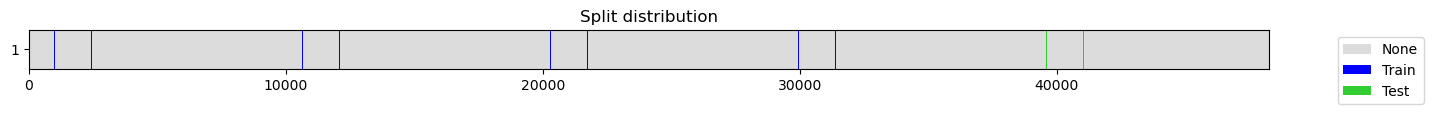

((#268) [143,287,431,575,719,863,1007,1151,1295,1439...],
 (#67) [38735,38879,39023,39167,39311,39455,39599,39743,39887,40031...])

In [21]:
if config.analysis_mode == 'online': 
    splits = get_forecasting_splits(
        df = df_train, 
        fcst_history = config.w,
        fcst_horizon = 1,
        stride = config.stride, 
        test_size = 0.2,
        show_plot = True
    )
    #    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X_strided)), valid_size=config.valid_size)

splits


## MVP - Encoder training
> Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [22]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [23]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

(48240, 1, 4320)


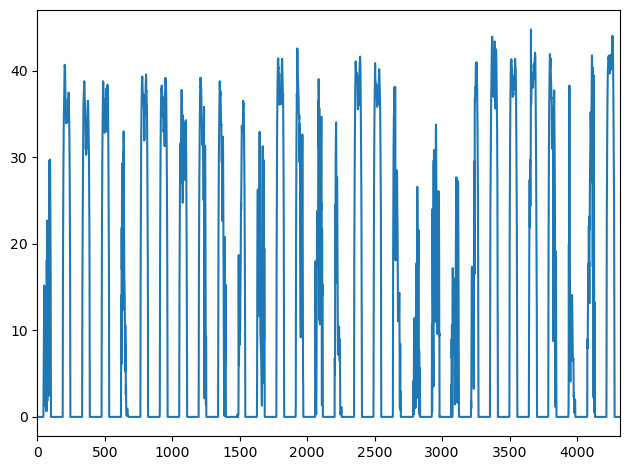

In [24]:
print(X.shape)
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
dls.show_at(0)

#### Check dls

In [25]:
print("X ~", X.shape) 
print("dls batch size", dls.bs)


X ~ (48240, 1, 4320)
dls batch size 268


### Build MVP TS Learner

In [26]:
if not window_size_percentage:
    window_size = ensure_expected_window_size(config.mvp_ws)
else:
    window_size = config.mvp_ws
window_size

[0.0002314814814814815, 4320]

In [27]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, 
                   InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                       window_size=window_size, 
                       future_mask = config.mask_future, 
                       target_dir='./models', 
                       sync = config.mask_sync, 
                       stateful = config.mask_stateful,
                       fname=f'encoder_MVP',
                       verbose=False
                    ), y_range=[X.min(), X.max()])

In [28]:
check_expected_window_size(learn, config.mvp_ws, True)

obtained percentage [0.0002314814814814815, 4320]
obtained absolute [1, 4320]


True

#### Check learner

In [29]:
print("learn dls.bs",  learn.dls.bs)

learn dls.bs 268


### Example mask

#### Create mask

In [30]:
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

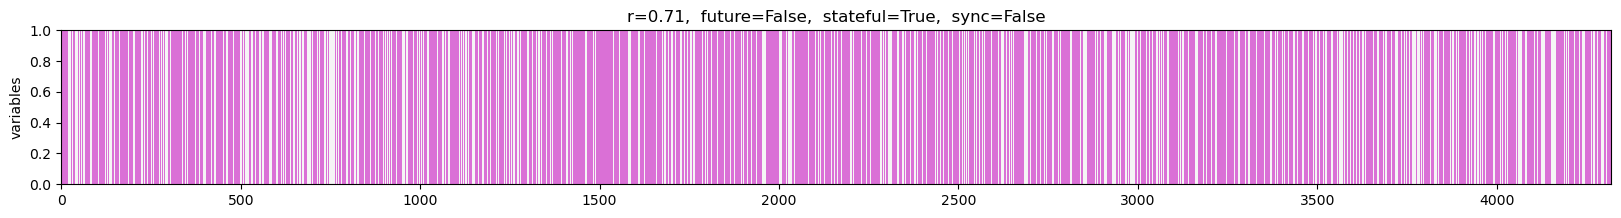

In [31]:
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 ## Check window size configuration

### Check config attributes

In [32]:
expected_window_size = config.mvp_ws
print("w", config.w, "mvp_ws", config.mvp_ws)
print("expected ", expected_window_size)
print(*config.mvp_ws)
np.random.randint(*config.mvp_ws)

w 4320 mvp_ws [1, 4320]
expected  [1, 4320]
1 4320


3333

### Check obtained attributes

In [33]:
# Find MVP calback
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
print("obtained ", obtained_window_size)
obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))
print("obtained ", obtained_window_size)

obtained  [0.0002314814814814815, 4320]
obtained  [1, 4320]


In [34]:
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


#### Check w1 < w2 for MVP random window size selection

In [35]:
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    print(obtained_window_size)
    ws = np.random.randint(*obtained_window_size)
    print(ws)

[1, 4320]
1307


#### Check self.x.shape[-1] for np.random.randint(0, self.x.shape[-1] - ws) MMVP calculus

In [36]:
#Get data batch
x = next(iter(dls.train))
print("x", x)
x_data=x[0]
print("Data shape: " + str( x_data.shape))
time_serie_len = x_data.shape[-1]
print("Time serie len: " + str( time_serie_len))
#Just in case
diff = time_serie_len - ws
print("diff time serie len - ws:", diff)
result = np.random.randint(0, diff)
print("ws ", ws, "diff", diff, "result",  result)

x (TSTensor(samples:268, vars:1, len:4320, device=cuda:0, dtype=torch.float32),)
Data shape: torch.Size([268, 1, 4320])
Time serie len: 4320
diff time serie len - ws: 3013
ws  1307 diff 3013 result 6


### Train the model

In [37]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
print("obtained ", obtained_window_size)

obtained  [0.0002314814814814815, 4320]


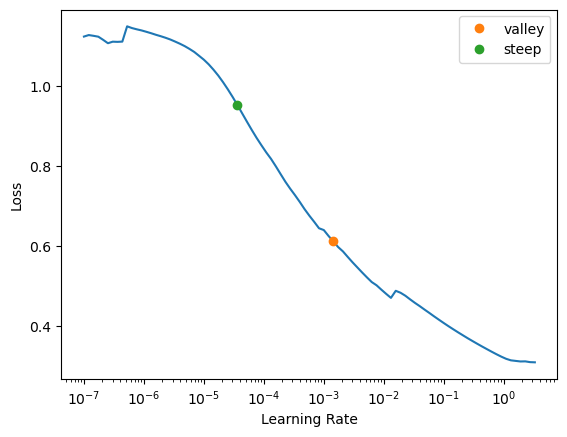

In [38]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

In [39]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
print("obtained ", obtained_window_size)

obtained  [1, 4320]


In [40]:
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, print_flag=True):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

obtained percentage [1, 4320]
obtained absolute [4320, 4320]
[1, 4320]
[0.0002314814814814815, 4320]
1


epoch     train_loss  valid_loss  time    
0         1.209516    0.738337    00:00     


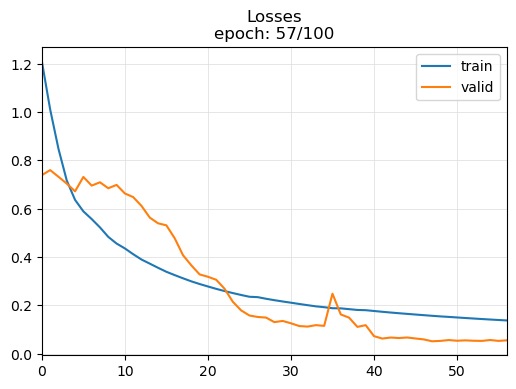

1         1.010614    0.759167    00:00     
2         0.847531    0.731733    00:00     
3         0.716263    0.703429    00:00     
4         0.635972    0.671331    00:00     
5         0.588525    0.731016    00:00     
6         0.556714    0.695112    00:00     
7         0.522120    0.708783    00:00     
8         0.482937    0.684195    00:00     
9         0.455350    0.698007    00:00     
10        0.435126    0.662567    00:00     
11        0.411277    0.647544    00:00     
12        0.389234    0.611221    00:00     
13        0.372177    0.562589    00:00     
14        0.354903    0.539032    00:00     
15        0.338466    0.530626    00:00     
16        0.324733    0.477120    00:00     
17        0.311531    0.407123    00:00     
18        0.298935    0.365214    00:00     
19        0.287885    0.327652    00:00     
20        0.277677    0.317887    00:00     
21        0.267845    0.305410    00:00     
22        0.258794    0.268475    00:00     
23        

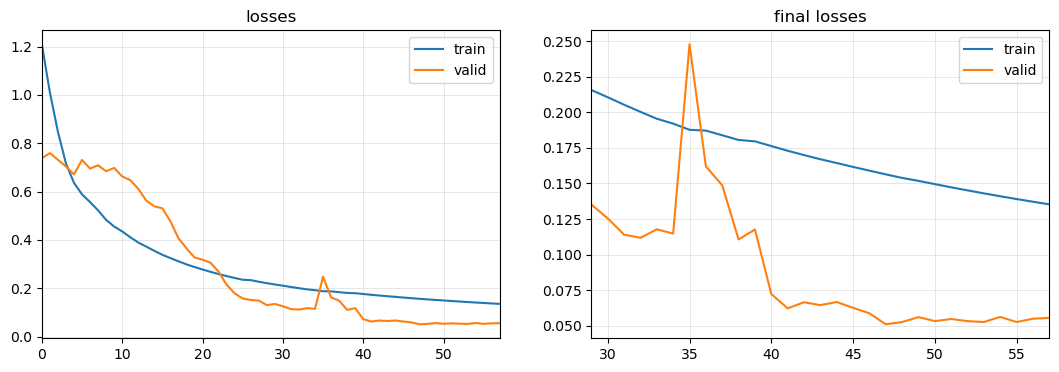

In [41]:
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

#### Validate the model

In [42]:
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, print_flag=True):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

obtained percentage [1, 4320]
obtained absolute [4320, 4320]
[1, 4320]
[0.0002314814814814815, 4320]
1


In [43]:
learn.validate()

not enough values to plot a chart


(#1) [0.9443069100379944]

## Visualize predictions

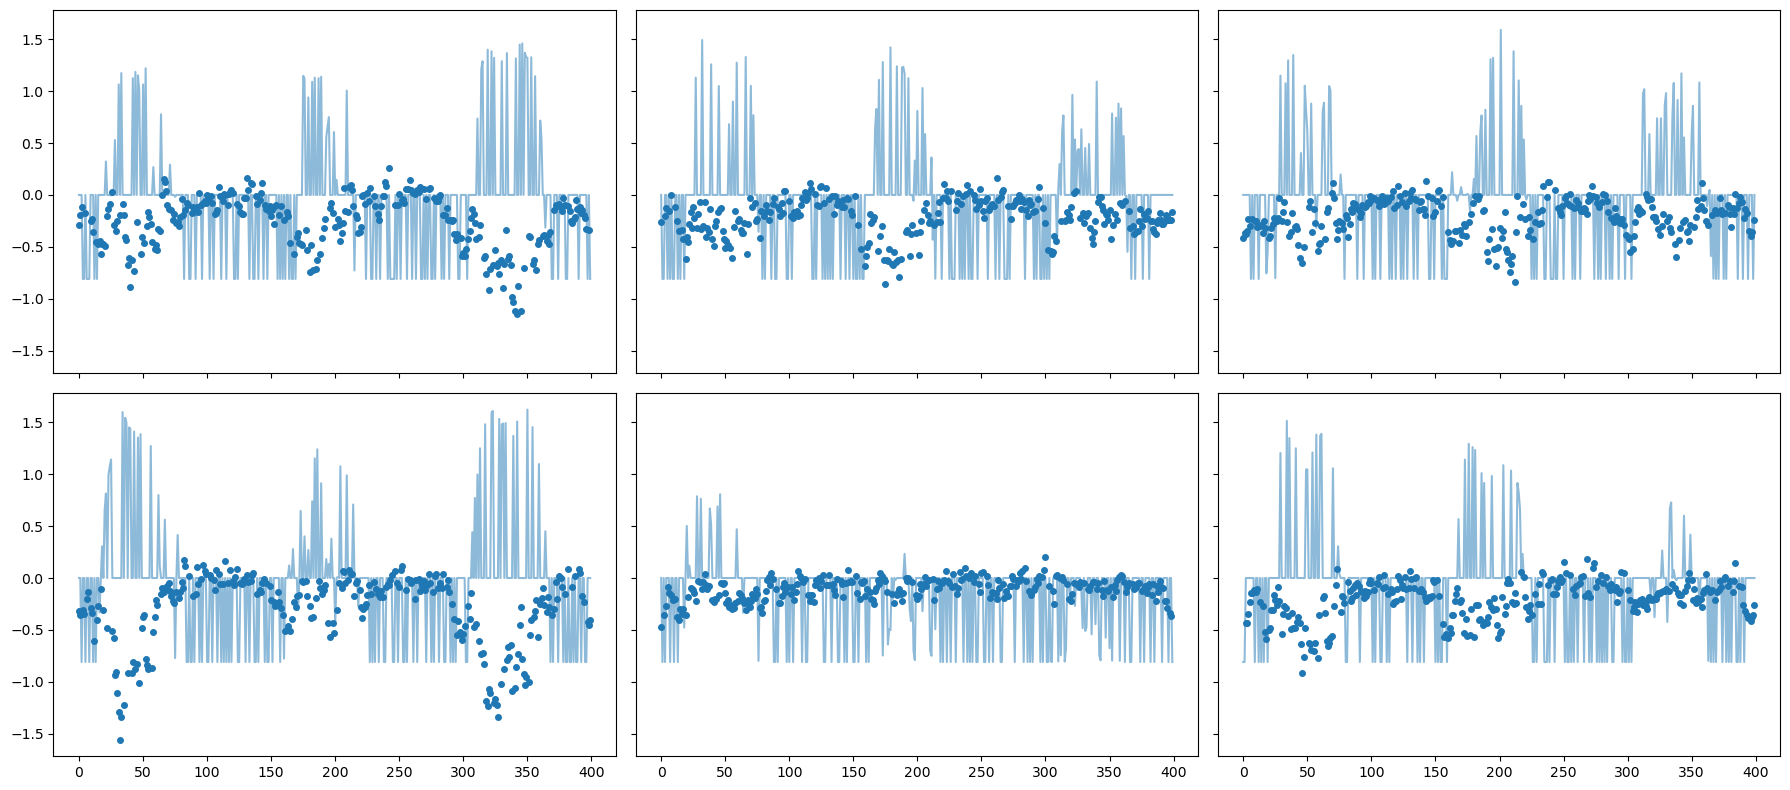

In [44]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [45]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

In [46]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp-SWV', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [47]:
run.finish()

epoch,58
eps_0,1e-05
eps_1,1e-05
lr_0,0.00089
lr_1,0.00089
mom_0,0.88858
mom_1,0.88858
raw_loss,0.07331
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.13526


## Checking 
> Comment: Remember we load the learner without the dataset

In [48]:
aux_learn.dls

In [49]:
aux_learn.dls.bs

1

In [50]:
learn.dls.bs

268

In [ ]:
reset_kernel=True
if reset_kernel:
    import os
    os._exit(00)